In [1]:
#mlp_model.ipynb
#
#by Joe Hahn
#joe.hahn@oracle.com
#9 July 2018
#
#train an mlp model on the XO dataset, this executes in about X minutes on m4.xlarge instance

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 13
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate smallish sample training data...so that model hyperparameters can be tuned quickly
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
train = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
N_classes = len(train['class'].unique())
print 'N_classes = ', N_classes
train.tail()

N_classes =  3


,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,2.989824,5.948659,6.657747,1.105067,B,0.0,0.0,1.0
19996,19996,0.997077,-4.834852,4.936594,-1.367421,B,0.0,0.0,1.0
19997,19997,-1.183867,-4.177891,4.342386,-1.846922,B,0.0,0.0,1.0
19998,19998,3.886011,-4.681130,6.083918,-0.877943,X,1.0,0.0,0.0
19999,19999,2.345296,-2.628300,3.522552,-0.842238,X,1.0,0.0,0.0


In [5]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

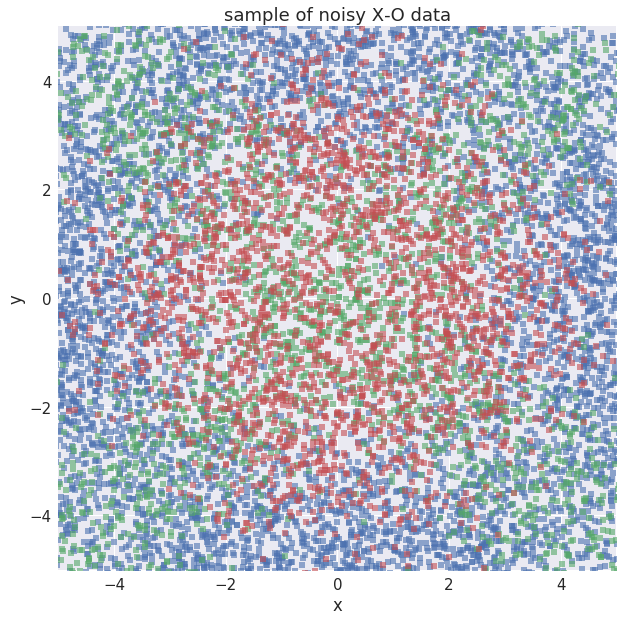

In [6]:
#scatterplot of noisy training data
df = train
xy_rng = (-5, 5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('sample of noisy X-O data')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
#plt.savefig('figs/training_data.png')

In [7]:
#balance training data, randomize rows, and then select x-features and target variables ie class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
df = train
idx_O = (df['class'] == 'O')
idx_X = (df['class'] == 'X')
idx_B = (df['class'] == 'B')
df = df[idx_O].append(df[idx_X]).append(df[idx_B].sample(n=idx_O.sum()))
df['ran_num'] = np.random.uniform(size=len(df))
train_balanced = df.sort_values('ran_num')
print train_balanced.groupby('class')['id'].count()
x = train_balanced[x_cols].values
y = train_balanced[y_cols].values
x.shape, y.shape

class
B    2451
O    2451
X    2705
Name: id, dtype: int64


((7607, 2), (7607, 3))

In [8]:
#this helper function assembles a simple MLP classifier
def mlp_classifier(layers, dropout_fraction=None):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    model = Sequential()
    #input layer
    N = layers[0]
    model.add(Dense(N, activation='elu', input_shape=(N_inputs,)))
    if (dropout_fraction):
        model.add(Dropout(dropout_fraction))
    #hidden layers
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
        if (dropout_fraction):
            model.add(Dropout(dropout_fraction))
    #output layer
    N = layers[-1]
    #model.add(Dense(N, activation='linear'))
    model.add(Dense(N, activation='sigmoid'))
    #model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [9]:
#build MLP classification model 
N_inputs = x.shape[1]
N_middle = N_inputs*N_classes
N_outputs = N_classes
layers = [N_inputs, N_middle, N_outputs]
dropout_fraction = 0.3
print 'layers = ', layers
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
model.summary()

layers =  [2, 6, 3]
dropout_fraction =  0.3


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 18        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [11]:
#fit model to the training data.
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="tf_logs/{}".format(time()))
N_training_epochs = 20
batch_size = 1000
#fit_history = model.fit(x, y, epochs=N_training_epochs, batch_size=batch_size, verbose=0, \
#    validation_data=(x_valid, y_valid), callbacks=[tensorboard])